<a href="https://colab.research.google.com/github/ErikaRiv/HateSpeech/blob/main/BertAgresividad_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BERT + CNN for Hate Speech Recognition.

Fuente del código https://github.com/ZeroxTM/BERT-CNN-Fine-Tuning-For-Hate-Speech-Detection-in-Online-Social-Media


Ajustamos el modelo para el caso en que los tweets son en español y sólo clasificamos Ofensivo/No Ofensivo.

# Librerías

In [ ]:
!pip install transformers==3.0.0
!pip install emoji
import gc
#import os
import emoji as emoji
import re
import string
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from transformers import AutoModel
from transformers import BertModel, BertTokenizer

     |████████████████████████████████| 757kB 8.4MB/s 
     |████████████████████████████████| 901kB 53.9MB/s 
     |████████████████████████████████| 1.2MB 48.6MB/s 
     |████████████████████████████████| 3.0MB 41.3MB/s 
     |████████████████████████████████| 133kB 8.4MB/s 


# BERT Architecture

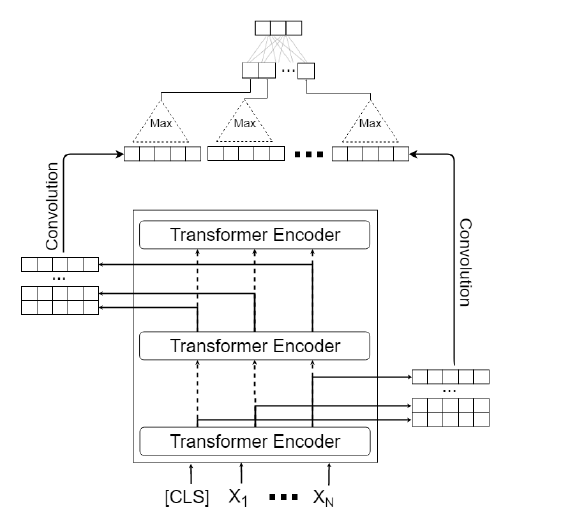

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.conv = nn.Conv2d(in_channels=13, out_channels=13, kernel_size=(3, 768), padding=True) #convolutional 
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=3, stride=1)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(442, 3) # before : 442 with max_length 36 # 806 with max_length 64
        self.flat = nn.Flatten()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        _, _, all_layers = self.bert(sent_id, attention_mask=mask, output_hidden_states=True) #Estados ocultos
        # all_layers 
        x = torch.transpose(torch.cat(tuple([t.unsqueeze(0) for t in all_layers]), 0), 0, 1)
        del all_layers
        gc.collect() #Garbage Collector
        torch.cuda.empty_cache()
        x = self.pool(self.dropout(self.relu(self.conv(self.dropout(x)))))
        x = self.fc(self.dropout(self.flat(self.dropout(x))))
        return self.softmax(x)

# Tweets

In [ ]:
# 1 implica agresión y 0 no agresivo
import os

In [ ]:
mex_train_labels="/content/drive/MyDrive/Colab Notebooks/material/mex_train_labels.txt"
mex_train="/content/drive/MyDrive/Colab Notebooks/material/mex_train.txt"
mex_val="/content/drive/MyDrive/Colab Notebooks/material/mex_val.txt"
mex_val_labels="/content/drive/MyDrive/Colab Notebooks/material/mex_val_labels.txt"

In [ ]:
def get_text_from_file(path_corpus, path_truth):
  tr_txt=[]
  tr_y=[]

  with open(path_corpus, "r") as f_corpus, open(path_truth, "r") as f_truth:
    for twitt in f_corpus:
      tr_txt+=[twitt]

    for label in f_truth:
      tr_y += [int(label)]
      #print(label)

  return tr_txt, tr_y

In [ ]:
tr_text, tr_y = get_text_from_file(mex_train,mex_train_labels)
val_text, val_y = get_text_from_file(mex_val,mex_val_labels)

In [ ]:
text_=tr_text+val_text
labels_=tr_y+val_y

In [ ]:
def read_dataset():
    data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/proyectoNLP/data/labeled_data.csv")
    data = data.drop(['count', 'hate_speech', 'offensive_language', 'neither'], axis=1)
    #data = data.loc[0:9599,:]
    print(len(data))
    return data['tweet'].tolist(), data['class']


def pre_process_dataset(values):
    new_values = list()
    # Emoticons
    emoticons = [':-)', ':)', '(:', '(-:', ':))', '((:', ':-D', ':D', 'X-D', 'XD', 'xD', 'xD', '<3', '</3', ':\*',
                 ';-)',
                 ';)', ';-D', ';D', '(;', '(-;', ':-(', ':(', '(:', '(-:', ':,(', ':\'(', ':"(', ':((', ':D', '=D',
                 '=)',
                 '(=', '=(', ')=', '=-O', 'O-=', ':o', 'o:', 'O:', 'O:', ':-o', 'o-:', ':P', ':p', ':S', ':s', ':@',
                 ':>',
                 ':<', '^_^', '^.^', '>.>', 'T_T', 'T-T', '-.-', '*.*', '~.~', ':*', ':-*', 'xP', 'XP', 'XP', 'Xp',
                 ':-|',
                 ':->', ':-<', '$_$', '8-)', ':-P', ':-p', '=P', '=p', ':*)', '*-*', 'B-)', 'O.o', 'X-(', ')-X']

    for value in values:
        # Remove dots
        text = value.replace(".", "").lower()
        text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text)
        users = re.findall("[@]\w+", text)
        for user in users:
            text = text.replace(user, "<user>")
        urls = re.findall(r'(https?://[^\s]+)', text)
        if len(urls) != 0:
            for url in urls:
                text = text.replace(url, "<url >")
        for emo in text:
            if emo in emoji.UNICODE_EMOJI:
                text = text.replace(emo, "<emoticon >")
        for emo in emoticons:
            text = text.replace(emo, "<emoticon >")
        numbers = re.findall('[0-9]+', text)
        for number in numbers:
            text = text.replace(number, "<number >")
        text = text.replace('#', "<hashtag >")
        text = re.sub(r"([?.!,¿])", r" ", text)
        text = "".join(l for l in text if l not in string.punctuation)
        text = re.sub(r'[" "]+', " ", text)
        new_values.append(text)
    return new_values


def data_process(data, labels):
    input_ids = []
    attention_masks = []
    dict_tweets=[]
    d_t={}
    i=0
    bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    for sentence in data:
        bert_inp = bert_tokenizer.__call__(sentence, max_length=36,
                                           padding='max_length', pad_to_max_length=True,
                                           truncation=True, return_token_type_ids=False)
        d_t[i]=sentence
        i=i+1
        dict_tweets.append((bert_inp['input_ids'],sentence))
        input_ids.append(bert_inp['input_ids'])
        attention_masks.append(bert_inp['attention_mask'])
    #del bert_tokenizer
    #gc.collect()
    #torch.cuda.empty_cache()
    input_ids = np.asarray(input_ids)
    attention_masks = np.array(attention_masks)
    labels = np.array(labels)
    return input_ids, attention_masks, labels


def load_and_process():
    data, labels = text_, np.array(labels_)
    num_of_labels = len(set(labels))
    input_ids, attention_masks, labels  = data_process(pre_process_dataset(data), labels)

    return input_ids, attention_masks, labels, data

# Funciones de Entrenamiento y Evaluación del Modelo

In [ ]:
# function to train the model
def train():
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds = []

    # iterate over batches
    total = len(train_dataloader)
    for i, batch in enumerate(train_dataloader):

        step = i+1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>'  *(filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}', end='')

        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        #sent_id = torch.tensor(sent_id).to(device).long()
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss += float(loss.item())

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        #preds = preds.detach().cpu().numpy()


        # append the model predictions
        #total_preds.append(preds)
        total_preds.append(preds.detach().cpu().numpy())

    gc.collect()
    torch.cuda.empty_cache()

    # compute the training loss of the epoch
    avg_loss = total_loss / (len(train_dataloader)*batch_size)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    # returns the loss and predictions
    return avg_loss, total_preds
# function for evaluating the model
def evaluate():
    print("\n\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    total = len(val_dataloader)
    for i, batch in enumerate(val_dataloader):
        
        step = i+1
        percent = "{0:.2f}".format(100 * (step / float(total)))
        lossp = "{0:.2f}".format(total_loss/(total*batch_size))
        filledLength = int(100 * step // total)
        bar = '█' * filledLength + '>' * (filledLength < 100) + '.' * (99 - filledLength)
        print(f'\rBatch {step}/{total} |{bar}| {percent}% complete, loss={lossp}, accuracy={total_accuracy}', end='')

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch
        del batch
        gc.collect()
        torch.cuda.empty_cache()
        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)

            total_loss += float(loss.item())
            #preds = preds.detach().cpu().numpy()

            #total_preds.append(preds)
            total_preds.append(preds.detach().cpu().numpy())

    gc.collect()
    torch.cuda.empty_cache()

    # compute the validation loss of the epoch
    avg_loss = total_loss / (len(val_dataloader)*batch_size)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

# Entrenamiento y Evaluación + Clasificación

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://morioh.com/p/eabbdfdd1f0b

In [ ]:
# Specify the GPU
# Setting up the device for GPU usage
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Load Data-set ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
input_ids, attention_masks, labels, data = load_and_process()
df = pd.DataFrame(list(zip(input_ids, attention_masks,data)), columns=['input_ids', 'attention_masks','tweets'])
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ class distribution ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither
# ~~~~~~~~~~ Split train data-set into train, validation and test sets  ~~~~~~~~~~#
train_text, temp_text, train_labels, temp_labels = train_test_split(df[['input_ids', 'attention_masks']], labels,
                             random_state=2018, test_size=0.2, stratify=labels)

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                         random_state=2018, test_size=0.5, stratify=temp_labels)

cuda


In [ ]:
df

,input_ids,attention_masks,tweets
0,"[101, 8840, 21877, 2953, 2139, 28681, 2080, 96...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",lo peor de todo es que no me dan por un tiempo...
1,"[101, 1037, 2474, 1058, 3654, 2053, 11915, 500...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",a la vga no seas mamón 45 putos minutos despué...
2,"[101, 5136, 2080, 10861, 8840, 1049, 1055, 140...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",considero que lo más conveniente seria que lo ...
3,"[101, 3449, 16266, 3540, 2139, 2771, 4654, 203...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",el marica de mi ex me tiene bloqueada de todo ...
4,"[101, 14163, 20009, 4078, 5051, 7507, 10259, 2...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",mujer despechadaya pinche amlo hazle esta que ...
...,...,...,...
6155,"[101, 9765, 2050, 19960, 3695, 16266, 3540, 24...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",esta medio marica la canción de let him burn y...
6156,"[101, 2033, 29536, 2100, 1037, 2310, 13807, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",me voy a vengar de todos mis amigos que me eti...
6157,"[101, 6289, 6525, 3050, 7570, 19908, 2015, 549...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",ahora los hombres tienen que andar con cuidado...
6158,"[101, 8038, 9765, 6977, 2038, 2696, 2474, 2310...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",ya estoy hasta la verga que solo me busquen cu...


In [ ]:
train_labels

array([1, 1, 1, ..., 0, 1, 1])

In [ ]:
del temp_text
gc.collect()
torch.cuda.empty_cache()

train_count = len(train_labels)
test_count = len(test_labels)
val_count = len(val_labels)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~ Import BERT Model and BERT Tokenizer ~~~~~~~~~~~~~~~~~~~~~#
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')
# bert = AutoModel.from_pretrained('bert-base-uncased')
# Load the BERT tokenizer
#tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Tokenization ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# for train set
train_seq = torch.tensor(train_text['input_ids'].tolist())
train_mask = torch.tensor(train_text['attention_masks'].tolist())
train_y = torch.tensor(train_labels.tolist())

# for validation set
val_seq = torch.tensor(val_text['input_ids'].tolist())
val_mask = torch.tensor(val_text['attention_masks'].tolist())
val_y = torch.tensor(val_labels.tolist())

# for test set
test_seq = torch.tensor(test_text['input_ids'].tolist())
test_mask = torch.tensor(test_text['attention_masks'].tolist())
test_y = torch.tensor(test_labels.tolist())
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

In [ ]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Create DataLoaders ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Freeze BERT Parameters ~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)
# push the model to GPU
model = model.to(device)

# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)


# loss function
cross_entropy = nn.NLLLoss()

# set initial loss to infinite
best_valid_loss = float('inf')

In [ ]:
# number of training epochs
epochs = 3
current = 1
# for each epoch
while current <= epochs:

    print(f'\nEpoch {current} / {epochs}:')

    # train model
    train_loss, _ = train()

    # evaluate model
    valid_loss, _ = evaluate()

    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'saved_weights.pth')

    # append training and validation loss
    #train_losses.append(train_loss)
    #valid_losses.append(valid_loss)

    print(f'\n\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    current = current + 1


Epoch 1 / 3:
Batch 154/154 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.02

Evaluating...
Batch 20/20 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.02, accuracy=0

Training Loss: 0.022
Validation Loss: 0.023

Epoch 2 / 3:
Batch 154/154 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.02

Evaluating...
Batch 20/20 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01, accuracy=0

Training Loss: 0.016
Validation Loss: 0.016

Epoch 3 / 3:
Batch 154/154 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.00% complete, loss=0.01

Evaluating...
Batch 20/20 |█████████████████████████████████████████████████████████████████

In [ ]:
# get predictions for test data
gc.collect()
torch.cuda.empty_cache()

with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    #preds = model(test_seq, test_mask)
    preds = preds.detach().cpu().numpy()


print("Performance:")
# model's performance
preds = np.argmax(preds, axis=1)
print('Classification Report')
print(classification_report(test_y, preds))

print("Accuracy: " + str(accuracy_score(test_y, preds)))

Performance:
Classification Report
              precision    recall  f1-score   support

           0       0.77      0.91      0.83       396
           1       0.75      0.51      0.61       220

    accuracy                           0.77       616
   macro avg       0.76      0.71      0.72       616
weighted avg       0.76      0.77      0.75       616

Accuracy: 0.7662337662337663


#Error Analysis

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Confusion Matrix

In [ ]:
confusion_matrix(test_y,preds)

array([[359,  37],
       [107, 113]])

Get the test tweets

In [ ]:
test_text

,input_ids,attention_masks
2152,"[101, 3582, 2033, 2149, 6692, 9488, 2702, 4895...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2725,"[101, 9765, 6977, 2038, 2696, 2474, 2310, 2892...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4213,"[101, 8915, 16405, 18352, 20868, 2172, 2080, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2195,"[101, 9033, 16405, 24612, 3022, 11113, 20409, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2812,"[101, 4372, 10286, 17713, 2050, 18499, 2474, 6...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...
6049,"[101, 1037, 1040, 2004, 11498, 3449, 9765, 738...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2401,"[101, 17214, 5638, 1050, 1049, 1055, 29542, 32...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
5027,"[101, 2149, 6692, 9488, 7367, 27390, 2080, 108...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4845,"[101, 27314, 2229, 21770, 26534, 2953, 2386, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
labels={0:'No Agresivo', 1: 'Agresivo'}

In [ ]:
df['tweets'][0]

'lo peor de todo es que no me dan por un tiempo y luego vuelven estoy hasta la verga de estl\n'

***The missclassified ones***

In [ ]:
y=np.array(test_y)
y_h=preds  
for i,t in enumerate(test_text.index):
  if y[i] != y_h[i]:
    print('tweet: %s'%df['tweets'][t],'\n')
    print('True: %s' %labels[y[i]],'\n')
    print('True: %s' %labels[y_h[i]],'\n')

tweet: te puedes ir mucho a la verga si solo vas a estar en las buenas
 

True: Agresivo 

True: No Agresivo 

tweet: ensartada por la panocha y con verga en la boca #putayo en @usuario 💋💋💋🔥🔥🔥
 

True: No Agresivo 

True: Agresivo 

tweet: puto desmadre reforma pito metrobus! 😩 putos todos! 😡
 

True: Agresivo 

True: No Agresivo 

tweet: lo de messi se me hace muy chingón pinches argentinos se pasan de verga con el lo de panamá e islandia se me hace poca madre. y vidal joto
 

True: Agresivo 

True: No Agresivo 

tweet: todos los putos bondis dr mierda que vienen a tribunales cruzan la 9 de julio y van por donde se les canta el orto forros
 

True: No Agresivo 

True: Agresivo 

tweet: las peores putas son esas que son motolitas por eso es que yo soy como soy sin importarme nada ✌🏻una diabla en un mundo de santas falsas😈
 

True: Agresivo 

True: No Agresivo 

tweet: venir a pagar el cable y ahorrar para comprarle ropa a mi novia no me hace menos hombre putos.
 

True: No Agresivo 

T

Human corders consider homophobic slurs to be hateful.

In [ ]:
text_test=[]
for i,t in enumerate(test_text.index):
  text_test.append(df['tweets'][t])

In [ ]:
def get_misccl(word):
  y=np.array(test_y)
  for i,t in enumerate(text_test):
    aux=t.split(' ')
    if word in aux:
      if y[i] != preds[i]:
        print('tweet: %s' %t,'\n pred: %s'%labels[preds[i]], '\n true: %s' %labels[y[i]],'\n')

In [ ]:
get_misccl('puto')

tweet: puto desmadre reforma pito metrobus! 😩 putos todos! 😡
 
 pred: No Agresivo 
 true: Agresivo 

tweet: no desayuné bien por no salir tarde y el puto chófer viene tragando verga en el aire... ya mejor llévame cthulhu 😓
 
 pred: No Agresivo 
 true: Agresivo 

tweet: gente que cuando va a cinépolis y empuja al momento de entrar; eh we los asientos están asignados no seas tan maldito naco puto indio.
 
 pred: No Agresivo 
 true: Agresivo 

tweet: vrg q me digan del dobladillo del pantalón es como si en media me dijeran de subirme las calcetasme tiene hasta la madre el puto carlos
 
 pred: No Agresivo 
 true: Agresivo 

tweet: juego mil veces mejor que el puto samudio me cago en todos.
 
 pred: No Agresivo 
 true: Agresivo 

tweet: #cosasquememolestan el puto tráfico hecho por gente inculta que no se porque putas madres aprendió a manejar
 
 pred: No Agresivo 
 true: Agresivo 

tweet: por está madre me agarré a vergazos con el de la combi y no le pagué el puto decía que ya no valen.
 


In [ ]:
get_misccl('puta')

tweet: @usuario carcel a @usuario x golpeador maricon y drogadicto. su puta madre no lo educo por eso lo agarraba de a perrito ernesto alonso putoteee
 
 pred: No Agresivo 
 true: Agresivo 

tweet: puta selección mas marica vayan a jugar con laso monjas
 
 pred: No Agresivo 
 true: Agresivo 

tweet: con todo respeto y educación campus tú y tu quinto semestre pueden tomar la puerta e irse a chigar toda su puta madre
 
 pred: Agresivo 
 true: No Agresivo 

tweet: @usuario q gusto m daria q peru elimine a la argentina y la concha d la perra mas puta d argentina la madre d @usuario
 
 pred: No Agresivo 
 true: Agresivo 

tweet: 📞bete ala puta chingada madre y amy dejame enpaz lla parale!!
 
 pred: No Agresivo 
 true: Agresivo 

tweet: pero esa réplica sin sentido que verga putos jueces de mierda traigan a @usuario la puta madre.
 
 pred: No Agresivo 
 true: Agresivo 



In [ ]:
get_misccl('verga')

tweet: te puedes ir mucho a la verga si solo vas a estar en las buenas
 
 pred: No Agresivo 
 true: Agresivo 

tweet: ensartada por la panocha y con verga en la boca #putayo en @usuario 💋💋💋🔥🔥🔥
 
 pred: Agresivo 
 true: No Agresivo 

tweet: lo de messi se me hace muy chingón pinches argentinos se pasan de verga con el lo de panamá e islandia se me hace poca madre. y vidal joto
 
 pred: No Agresivo 
 true: Agresivo 

tweet: dayana te ves bien rica mi amor con ganas de darte verga bien rico
 
 pred: No Agresivo 
 true: Agresivo 

tweet: "llégale a la verga pinche pendejo" es el título de una canción que estoy escribiendo. es de amor.
 
 pred: Agresivo 
 true: No Agresivo 

tweet: no desayuné bien por no salir tarde y el puto chófer viene tragando verga en el aire... ya mejor llévame cthulhu 😓
 
 pred: No Agresivo 
 true: Agresivo 

tweet: vengo a que me pelen la verga todos o no @usuario
 
 pred: No Agresivo 
 true: Agresivo 

tweet: yo ahorita que me enfrente a the end en metal gear soli

In [ ]:
get_misccl('mamasita')

tweet: yo t doy verga mamasita asta q t tiemblen las piernas y para q mames asta q te canses y si te gusta ps
 
 pred: No Agresivo 
 true: Agresivo 



# Word Cloud

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/proyectoNLP/data/labeled_data.csv")
data = data.drop(['Unnamed: 0','count', 'hate_speech', 'offensive_language', 'neither'], axis=1)

In [ ]:
data_tweets=pre_process_dataset(data['tweet'].tolist())

In [ ]:
data_tweets

In [ ]:
import nltk
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
text = " ".join(tw for tw in text_)
text

'lo peor de todo es que no me dan por un tiempo y luego vuelven estoy hasta la verga de estl\n a la vga no seas mamón 45 putos minutos después me dices que apenas sales no me querías avisar en 3 horas? 😑\n considero que lo más conveniente seria que lo retes a unos vergazos mi jelipe! rómpele la madre a ese pinchi joto!\n el marica de mi ex me tiene bloqueada de todo así  uno no puede admirar la "belleza" de su garnacha 😂\n mujer despechadaya pinche amlo hazle esta que se pela la loca #reynosafollow #reynosa\n putos. no tienen madre. ambriados mantenidos. ojetes. como es posible. mejor matarlos\n ustedes si puden andar de chanceros pero cuidadito y seamos nosotras porque luego luego empiezan a mamar hijos de la chingada.\n @usuario jajjaja te digo esa madre si está buena ajjaja\n odio los putos trámites de titulación 😡😡😡😡😡😡😡😡😡😡😡 pero me urge la precedula.\n @usuario no te equivocabas mi madre y tu tenían muchísima razón siempre es mejor lo que viene 💚\n "no me importa lo que digan esos 

In [ ]:
import nltk
#Este proceso puede hacerse antes de forma manual, descargar las stopwords de la librería nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words_sp = set(stopwords.words('spanish'))      

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def get_cloud(text,title):
  stopwords = set(STOPWORDS)
  stopwords.update(["drink", "now", "wine", "flavor", "flavors"])

  # Generate a word cloud image
  #wordcloud = WordCloud(width=1500,height=1000,max_words=500,stopwords=stopwords, background_color="white").generate(text)

  font = '/content/drive/MyDrive/Colab Notebooks/Quicksand-Bold.ttf'
  custom_mask = np.array(Image.open("/content/drive/MyDrive/Colab Notebooks/heart.png"))
  word_cloud = WordCloud(font_path=font, mask=custom_mask,
                       width=4000,
                       height=4000,
                       colormap='PuRd',
                       margin=0,
                       max_words=100, 
                       stopwords=stop_words_sp,
                       background_color="white").generate(text)

  image_colors = ImageColorGenerator(custom_mask)
  word_cloud.recolor(color_func=image_colors)
  plt.figure(figsize=(12, 12))
  plt.imshow(word_cloud, interpolation='gaussian')
  plt.axis("off")
  plt.title(title)
  plt.show()

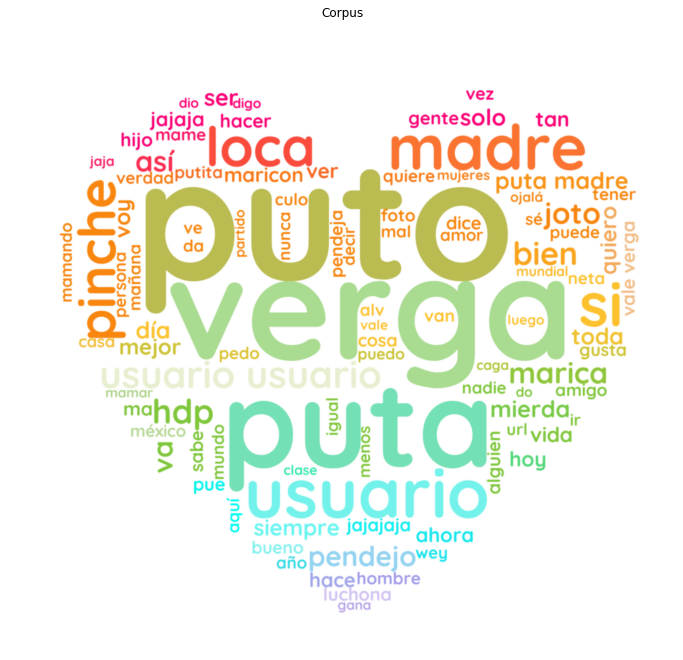

In [ ]:
get_cloud(text,'Corpus')

In [ ]:
labels_

In [ ]:
HS_tweets=" ".join(tw for i,tw in enumerate(text_) if labels_[i]==0)

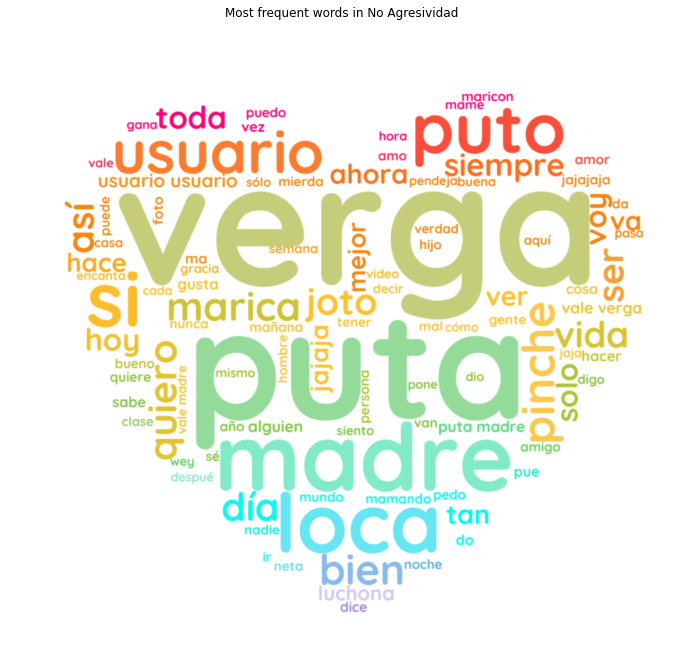

In [ ]:
get_cloud(HS_tweets,'Most frequent words in No Agresividad')

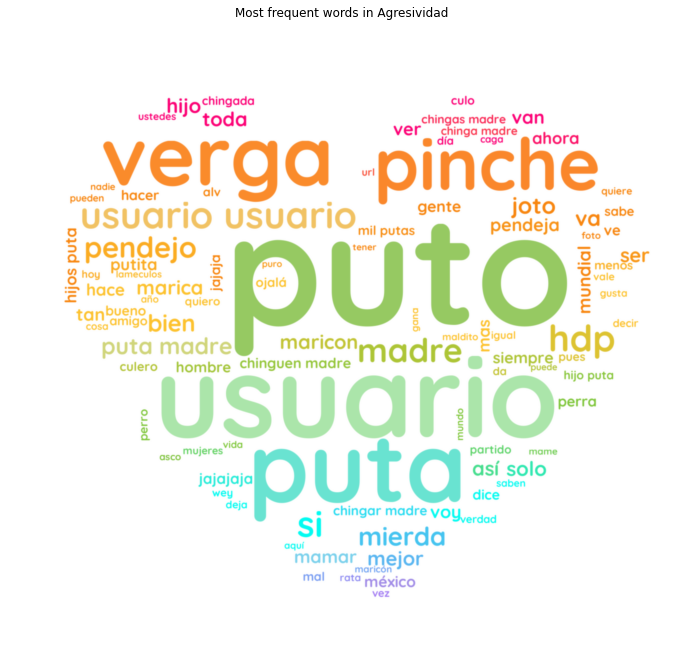

In [ ]:
OL_tweets=" ".join(tw for i,tw in enumerate(text_) if labels_[i]==1)
get_cloud(OL_tweets,'Most frequent words in Agresividad')